In [1]:
import torch 
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms

import copy
from PIL import Image
import matplotlib.pyplot as plt
from typing import List

In [2]:
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        ## C,1,1 shape for broadcasting
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [4]:
def gram_matrix(x):
    a, b, c, d = x.size()  # a=batch size(=1)
                            # b=number of feature maps
                            # (c,d)=dimensions of a f. map (N=c*d)

    features = x.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G/(a * b * c * d)

In [105]:
class style_transfer_model(nn.Module):
    
    def __init__(self, mean, std, feature_extractor):
        super(style_transfer_model, self).__init__()
        self.content_num = CONTENT_NUM # only one
        self.style_max_num = STYLE_MAX_NUM
        
        self.normalization = Normalization(mean, std)
        self.cnn = self.build_network(feature_extractor)
                
    def build_network(self, feature_extractor):
        self.conv_index = []
        
        conv_count = 0
        for i, layer in enumerate(feature_extractor):
            if isinstance(layer,nn.Conv2d) and conv_count < self.style_max_num:
                conv_count+=1
                self.conv_index.append(i)
            
        partial_model = feature_extractor[:max(self.conv_index)+2]
        return partial_model
        
    def forward(self, img):
        conv_feature_map = []
        img = self.normalization(img)
        for index, layer in enumerate(self.cnn):
            img = layer(img)
            if isinstance(layer,nn.Conv2d):
                conv_feature_map.append(img)
                
        return conv_feature_map

In [175]:
class customloss(nn.Module):
    
    def __init__(self, content_num:int = 4, style_max_num:int = 5):
        super(customloss, self).__init__()
        self.content_num = CONTENT_NUM # only one
        self.style_max_num = STYLE_MAX_NUM
        
    def styleloss(self, f, s):
        return F.mse_loss(gram_matrix(f), gram_matrix(s).detach())
    
    def contentloss(self, f, c):
        return F.mse_loss(f,c.detach())
        
    def forward(self, content: List[torch.Tensor], style: List[torch.Tensor], featuremap: List[torch.Tensor]):
        content_loss = 0
        style_loss = 0
        
        content_loss = self.contentloss(featuremap[self.content_num-1], content[self.content_num-1])
        for s in range(self.style_max_num): style_loss += self.styleloss(featuremap[s], style[s])
                
        return content_loss, style_loss

In [180]:
def run_style_transfer(model, content_img, style_img, input_img, 
                       num_steps=300, style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            featuremap = model(input_img)
            content_feature = model(content_img)
            style_feature = model(style_img)
            
            content_score, style_score = criterion(content_feature, style_feature, featuremap)

            loss = style_weight * style_score + content_weight * content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run[0]))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

# setting

In [163]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [164]:
device = 'cuda:0'

In [165]:
STYLE_MAX_NUM = 5
CONTENT_NUM = 4

# model

In [166]:
cnn = torchvision.models.vgg19(pretrained=True).features.to(device).eval()

In [167]:
model = style_transfer_model(mean=IMAGENET_MEAN, 
                             std=IMAGENET_STD,
                             feature_extractor=cnn)

In [176]:
criterion = customloss()

# start transfer

In [182]:
output = run_style_transfer(model,content_img, style_img, input_img)

run 50:
Style Loss : 0.000011 Content Loss: 4.872060

run 100:
Style Loss : 0.000004 Content Loss: 5.067833

run 150:
Style Loss : 0.000002 Content Loss: 4.642450

run 200:
Style Loss : 0.000001 Content Loss: 4.075586

run 250:
Style Loss : 0.000001 Content Loss: 3.821496

run 300:
Style Loss : 0.000001 Content Loss: 3.688864



# visualize

In [170]:
ToTensor = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor()  
])

In [181]:
content_img = ToTensor(Image.open('content.jpg')).unsqueeze(0).cuda()
style_img = ToTensor(Image.open('style.jpg')).unsqueeze(0).cuda()
input_img = content_img.clone()

In [172]:
def tensor_to_np(tensor):
    return tensor.permute(0,2,3,1).squeeze(0).detach().cpu().numpy() 

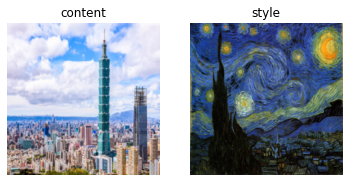

In [173]:
plt.subplot(1,2,1)
plt.title('content')
plt.axis('off')
plt.imshow(tensor_to_np(content_img))
plt.subplot(1,2,2)
plt.title('style')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))

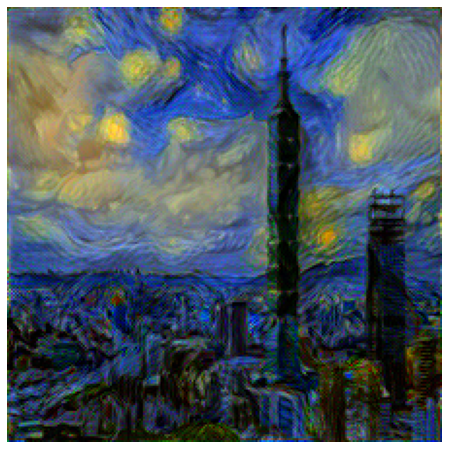

In [183]:
output_post = output.permute(0,2,3,1).squeeze(0).detach().cpu().numpy() 

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(output_post)